In [1]:
import torch
# import warnings
# warnings.filterwarnings("ignore")
print(torch.__version__)

2.0.1+cu118


In [2]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255),
    transforms.Resize((224, 224), antialias=False),
])

In [3]:
from torchvision.datasets import LFWPeople

dataset = LFWPeople('./data/', transform=transform, download=True)

Files already downloaded and verified


In [4]:
from torch.utils.data import random_split

train_ratio = 0.8

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, test_size])

In [5]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size)
val_loader = DataLoader(val_dataset, batch_size)

Text(0.5, 1.0, 'Roger_Lyons')

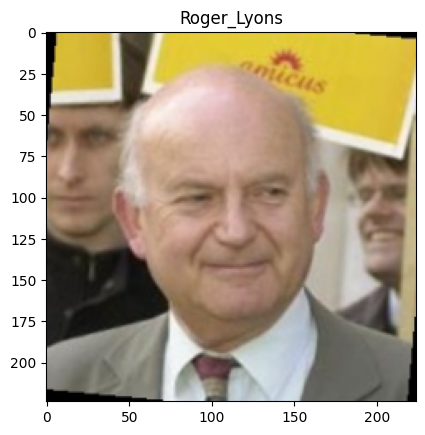

In [6]:
import matplotlib.pyplot as plt
import numpy as np

i = np.random.randint(len(dataset))

plt.imshow(dataset[i][0].permute(1, 2, 0) * 255)
plt.title(list(dataset.class_to_idx.keys())[list(dataset.class_to_idx.values()).index(dataset[i][1])])

In [7]:
num_classes = len(dataset.class_to_idx.keys())
num_classes

5749

In [8]:
import torch.nn as nn
import torchvision.models as models

class FaceRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(FaceRecognitionModel, self).__init__()
        self.feature_extractor = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-1])

        # self.feature_extractor.requires_grad_(False)
        
        self.classifier = nn.Linear(2048, num_classes)  

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        
        output = self.classifier(features)
        return self.softmax(output)


In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available():
        torch.cuda.empty_cache()

model = FaceRecognitionModel(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device

device(type='cuda')

In [10]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

epochs = 10

for epoch in range(epochs):

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    progress = tqdm(enumerate(train_loader))

    accuracies = []
    losses = []

    for i, batch in progress:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        pred = torch.argmax(outputs, dim=1)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append(accuracy_score(labels.cpu(), pred.cpu()))

        progress.set_description(f'Accuracy: {np.mean(accuracies)}, Loss: {np.mean(losses)}')

0it [00:08, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 6.00 GiB total capacity; 5.21 GiB already allocated; 0 bytes free; 5.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF